In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"huseyinovaaysel","key":"69c6a161e88032f18f953478ae4efea3"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sujaykapadnis/emotion-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/sujaykapadnis/emotion-recognition-dataset
License(s): CC-BY-NC-SA-4.0
emotion-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
with zipfile.ZipFile('/content/emotion-recognition-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [ ]:
import shutil
shutil.rmtree('/content/dataset/dataset/Ahegao')

In [ ]:
import os
for dirpath, dirnames, filenames in os.walk('/content/dataset'):
    print(f"There are {len(dirnames)} directiories and {len(filenames)} images in '{dirpath}'.")

There are 1 directiories and 1 images in '/content/dataset'.
There are 5 directiories and 0 images in '/content/dataset/dataset'.
There are 0 directiories and 1313 images in '/content/dataset/dataset/Angry'.
There are 0 directiories and 1234 images in '/content/dataset/dataset/Surprise'.
There are 0 directiories and 3934 images in '/content/dataset/dataset/Sad'.
There are 0 directiories and 4027 images in '/content/dataset/dataset/Neutral'.
There are 0 directiories and 3740 images in '/content/dataset/dataset/Happy'.


In [ ]:
from pickle import TRUE
import tensorflow as tf
IMG_SIZE =(224, 224)
data_path = '/content/dataset/dataset'

train_data = tf.keras.preprocessing.image_dataset_from_directory(data_path,
                                                                  label_mode = 'categorical',
                                                                  image_size = IMG_SIZE,
                                                                  subset = 'training',
                                                                  validation_split = 0.2,
                                                                  seed = 42,
                                                                  crop_to_aspect_ratio = True)
test_data = tf.keras.preprocessing.image_dataset_from_directory(data_path,
                                                                 label_mode = 'categorical',
                                                                 image_size  = IMG_SIZE,
                                                                 subset= 'validation',
                                                                 validation_split = 0.2,

                                                                 seed=42,
                                                                 crop_to_aspect_ratio = True)


Found 14248 files belonging to 5 classes.
Using 11399 files for training.
Found 14248 files belonging to 5 classes.
Using 2849 files for validation.


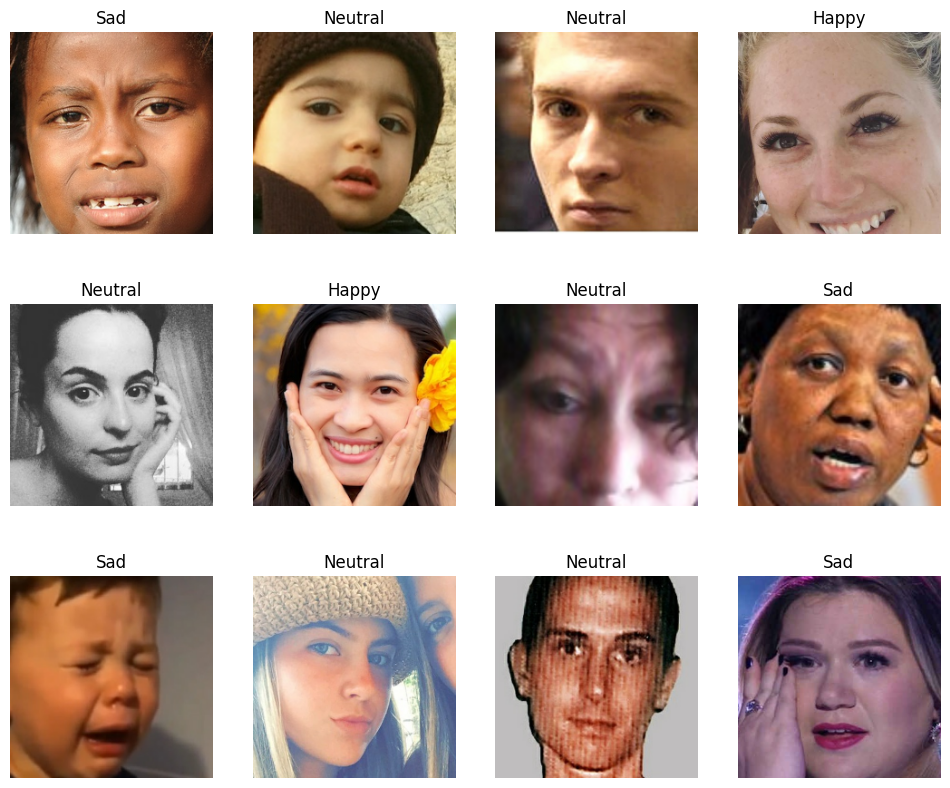

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
class_names = train_data.class_names
plt.figure(figsize=(12,10))

for images, labels in train_data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i +1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis('off')

In [ ]:
# -------------------------------------------
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

# --------------------------------------------



model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[224, 224, 3]),
    tf.keras.layers.Rescaling(1 / 255),
    tf.keras.layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',
                           activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=7, strides=2, padding='same',
                           activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=7, strides=2, padding='same',
                           activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=256, kernel_size=7, strides=2, padding='same',
                           activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=7, strides=2, padding='same',
                           activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=5, activation='softmax')
])


In [ ]:
 import tensorflow as tf
 model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy", 'f1_score'] )


In [ ]:
input_layer=tf.keras.layers.Input(shape=(224,224,3))

x=tf.keras.applications.resnet50.preprocess_input(input_layer)
base_model=tf.keras.applications.ResNet50(include_top=False,input_tensor=x)

avg=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output=tf.keras.layers.Dense(len(class_names),activation="softmax")(avg)

model=tf.keras.Model(inputs=input_layer,outputs=output)

In [ ]:
# base_model.trainabla=False

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False
#    buuuuuuuuuu

In [ ]:
initial_learning_rate=0.01
lr_scheduler=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=357,
    decay_rate=0.96
)

early_stopping=tf.keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)

checkpoint_cb=tf.keras.callbacks.ModelCheckpoint(
    "emotion_detector.keras",
    save_best_only=True
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    metrics=["accuracy","f1_score"]
)

model.fit(train_data,epochs=12,validation_data=test_data,
          callbacks=[early_stopping,checkpoint_cb])

Epoch 1/12
357/357 ━━━━━━━━━━━━━━━━━━━━ 109s 240ms/step - accuracy: 0.5277 - f1_score: 0.4752 - loss: 1.5707 - val_accuracy: 0.7192 - val_f1_score: 0.6972 - val_loss: 0.7452
Epoch 2/12
357/357 ━━━━━━━━━━━━━━━━━━━━ 113s 183ms/step - accuracy: 0.7562 - f1_score: 0.7461 - loss: 0.6226 - val_accuracy: 0.7382 - val_f1_score: 0.7248 - val_loss: 0.7219
Epoch 3/12
357/357 ━━━━━━━━━━━━━━━━━━━━ 62s 173ms/step - accuracy: 0.8201 - f1_score: 0.8161 - loss: 0.4501 - val_accuracy: 0.7532 - val_f1_score: 0.7492 - val_loss: 0.7084
Epoch 4/12
357/357 ━━━━━━━━━━━━━━━━━━━━ 81s 172ms/step - accuracy: 0.8653 - f1_score: 0.8652 - loss: 0.3291 - val_accuracy: 0.7378 - val_f1_score: 0.7156 - val_loss: 0.8638
Epoch 5/12
357/357 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.9288 - f1_score: 0.9341 - loss: 0.1935 - val_accuracy: 0.7582 - val_f1_score: 0.7635 - val_loss: 0.8294
Epoch 6/12
357/357 ━━━━━━━━━━━━━━━━━━━━ 82s 165ms/step - accuracy: 0.9577 - f1_score: 0.9575 - loss: 0.1216 - val_accuracy: 0.7389 - 

In [ ]:
def pred_and_plot(model, image_path, true_class, class_names):
    plt.figure(figsize=(10, 5))

    # Şəkli oxumaq və ölçüsünü dəyişmək
    image = mpimg.imread(image_path)
    image_resized = tf.image.resize(image, (224, 224))

    # Modelə uyğun şəkli genişləndirib proqnoz almaq
    pred_probs = model.predict(np.expand_dims(image_resized, axis=0))
    pred = class_names[np.argmax(pred_probs)]

    # Şəkli göstərmək
    plt.subplot(1, 2, 1)
    plt.imshow(image_resized / 255.0)
    color = "y" if pred == true_class else "r"
    plt.title(pred, color=color)
    plt.axis("off")

    # Proqnoz ehtimallarını bar chart ilə göstərmək
    plt.subplot(1, 2, 2)
    plt.bar(class_names, pred_probs[0])
    plt.xlabel("Class")
    plt.ylabel("Probability")

    print(f"Predicted class: {pred}, True class: {true_class}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: Sad, True class: Angry


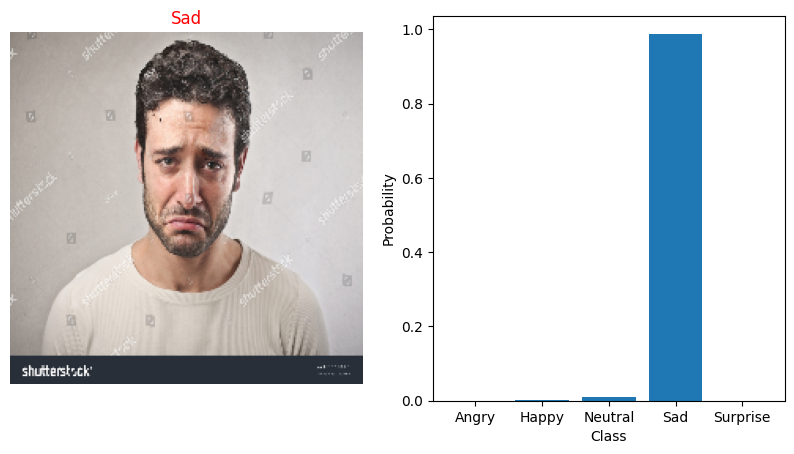

In [ ]:
pred_and_plot(model, "/content/tatlis.jpg", "Angry", class_names)